# Tabularize Weekly Time series
Conda environment: `time-series`   
10 Feb 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.creation import CyclicalFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

In [3]:
def c_mape(y: pd.Series, y_hat: pd.Series) -> np.float64:
    """
    Implements Mean Absolute Percent Error (MAPE).
    Args:
        y: actual values.
        y_hat: predicted values.
    Returns:
        MAPE value (Not in %)
    """
    if not (isinstance(y, pd.Series) and isinstance(y_hat, pd.Series)):
        y, y_hat = pd.Series(y), pd.Series(y_hat)
    mape = np.mean(np.abs((y - y_hat) / y))
    return np.round(mape, 4)

## 1) Input data
We have a weekly dataset

In [4]:
filename = "../datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
    ).rename(columns={"United Kingdom": "sales"})
df

,sales
week,
2009-12-06,"213,000.3500"
2009-12-13,"195,810.0400"
2009-12-20,"182,396.7400"
2009-12-27,"22,007.7700"
2010-01-03,0.0000
...,...
2011-11-13,"229,378.0100"
2011-11-20,"221,870.2900"
2011-11-27,"210,741.7600"


## 2) EDA

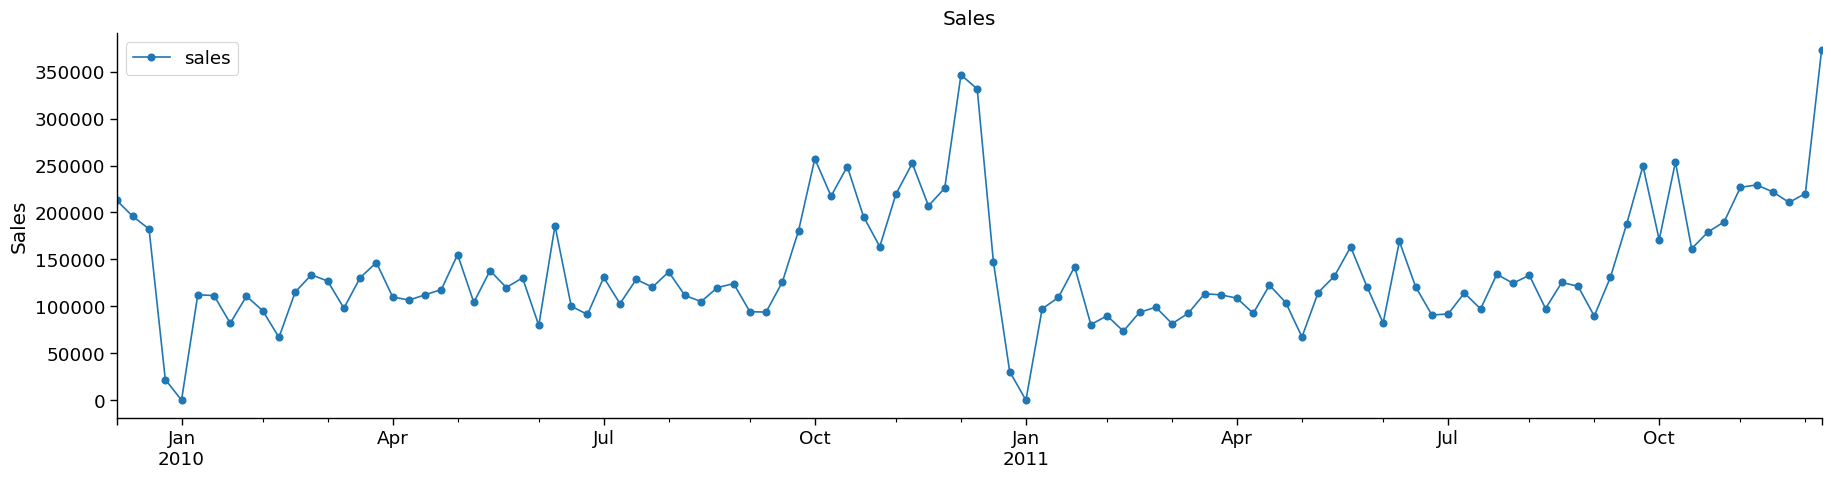

In [5]:
df.plot(marker="o")

plt.title("Sales")
plt.legend(loc="upper left")
plt.ylabel("Sales")
plt.xlabel("")
plt.show()

In [6]:
# Missing data
df.isnull().sum()

sales    0
dtype: int64

In [7]:
min_value = df.index.min()
max_value = df.index.max()
print(min_value, max_value)

2009-12-06 00:00:00 2011-12-11 00:00:00


We will see if we have missing timestamps in the index.

/var/folders/fd/vdpcq4tn1v3fbxg5302hgb980000gq/T/ipykernel_45978/2682064028.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputed = df_.fillna(method="ffill")


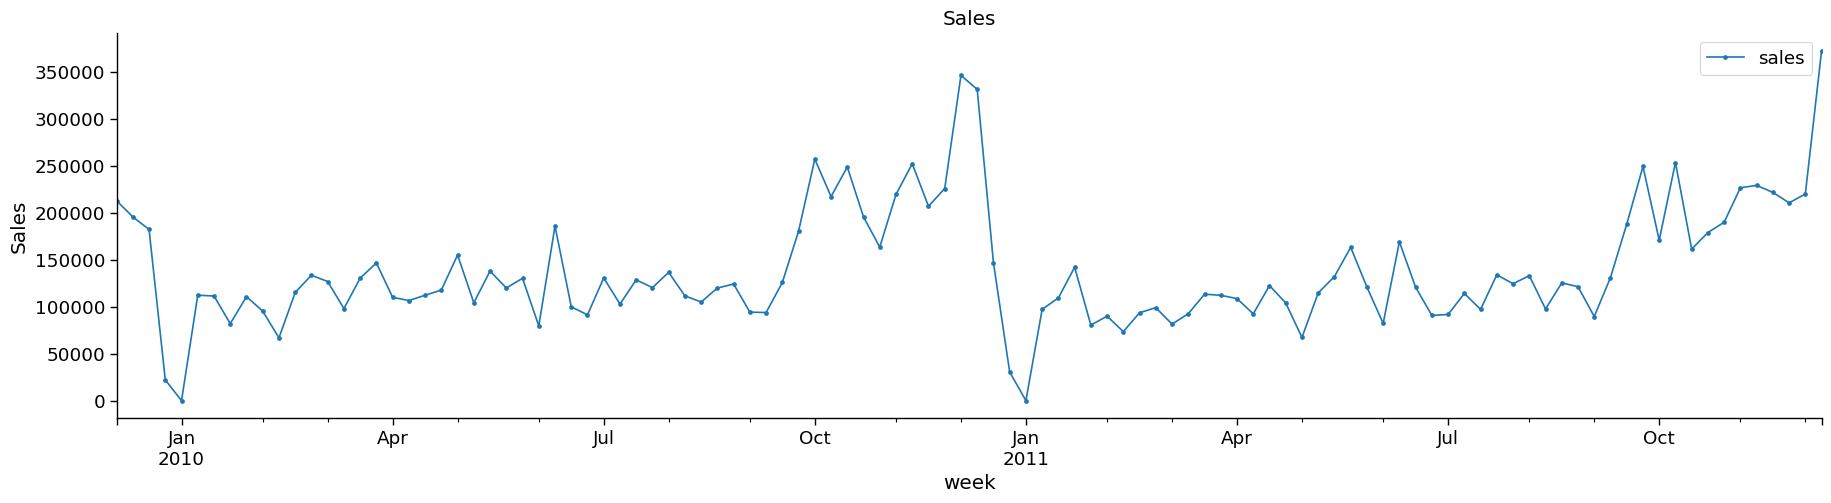

In [8]:
df_ = df.asfreq("1W")

# Imputation: forward fill method
df_imputed = df_.fillna(method="ffill")

# plot the time series.
ax = df_.plot(linestyle="-", marker=".")
# plot the imputed values on top, in red.
df_imputed[df_.isnull()].plot(ax=ax, legend=None, marker=".", color="r")

plt.title("Sales")
plt.ylabel("Sales")
plt.show()

### 2.1) Seasonality
Because we have weekly data, we will assess:
*  `monthly seasonality`
* `weekly seasonality`

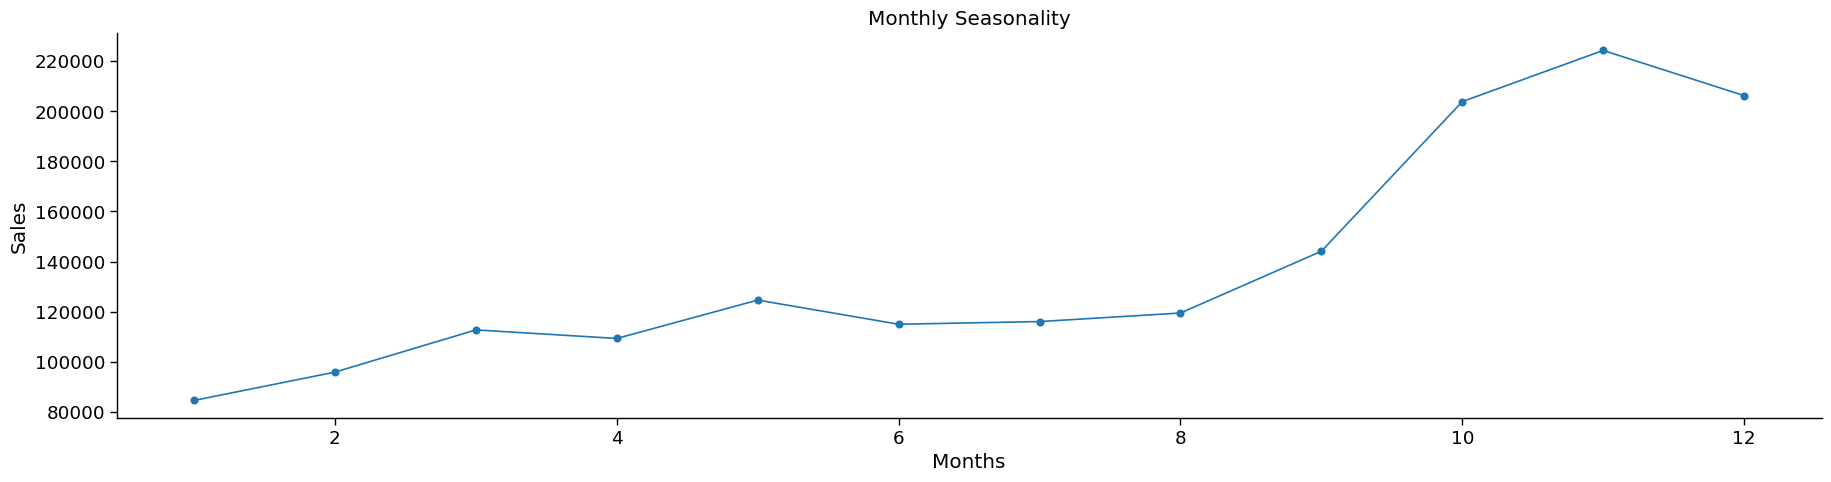

In [9]:
# Monthly seasonality
months = df.index.month
df.groupby(months)["sales"].mean().plot(marker="o")

plt.title("Monthly Seasonality")
plt.ylabel("Sales")
plt.xlabel("Months")
plt.show()

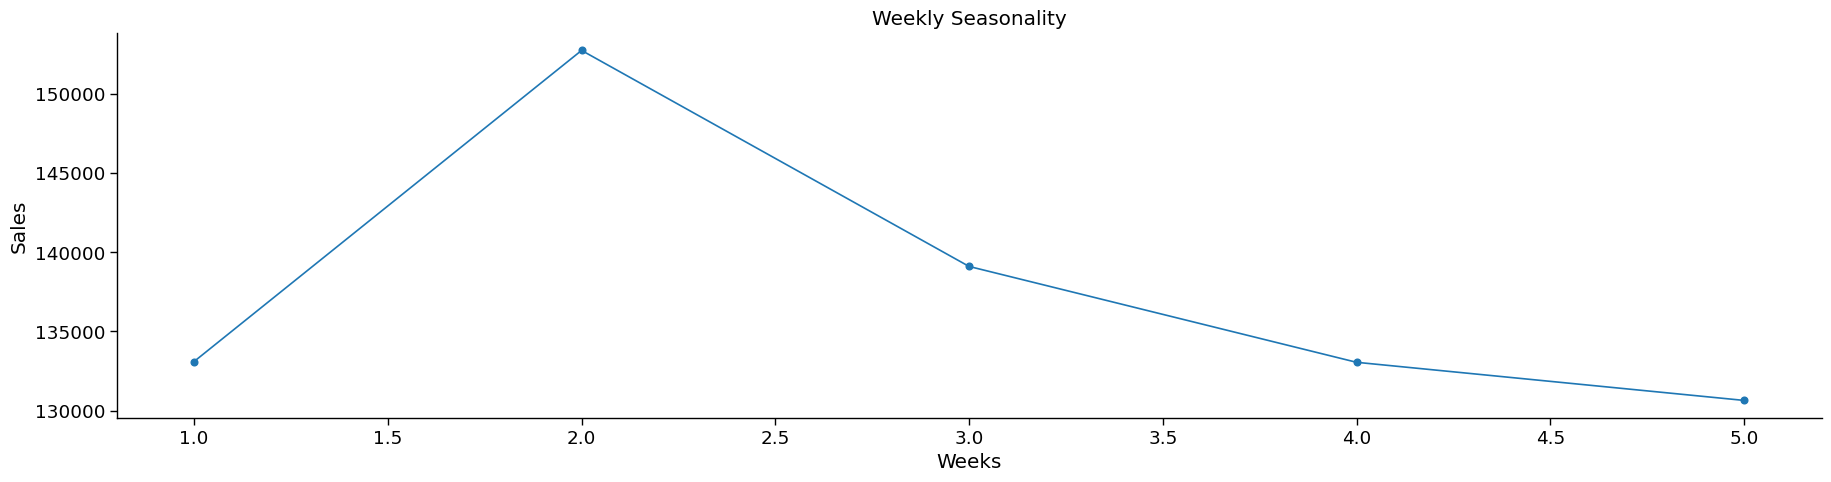

In [10]:
# Weekly seasonality
week_groups = ((df.index.day - 1) // 7) + 1
df.groupby(week_groups)["sales"].mean().plot(marker="o")

plt.title("Weekly Seasonality")
plt.ylabel("Sales")
plt.xlabel("Weeks")
plt.show()

## 3) Feature Engineering
* **1)** Datetime features
    * **1.1)** Month
    * **1.2)** Week of Month
* **2)** Cyclical features
* **3)** Lag features
    * **3.1)** Sales of the previous week
* **4)** Window features
    * **4.1)** Mean: of the previous 2 & 4 weeks. 
    * **4.2)** Max: of the previous 2 & 4 weeks.
    * **4.3)** Minx: of the previous 2 & 4 weeks.

### 3.1) Datetime features

In [11]:
df["month"] = df.index.month
df["week_month"] = ((df.index.day -1) //7) + 1
df

,sales,month,week_month
week,,,
2009-12-06,"213,000.3500",12,1
2009-12-13,"195,810.0400",12,2
2009-12-20,"182,396.7400",12,3
2009-12-27,"22,007.7700",12,4
2010-01-03,0.0000,1,1
...,...,...,...
2011-11-13,"229,378.0100",11,2
2011-11-20,"221,870.2900",11,3
2011-11-27,"210,741.7600",11,4


### 3.2) Cyclical features

In [12]:
cyclical = CyclicalFeatures(
    variables=["month", "week_month"],  
    drop_original=False,
)

df = cyclical.fit_transform(df)
df

,sales,month,week_month,month_sin,month_cos,week_month_sin,week_month_cos
week,,,,,,,
2009-12-06,"213,000.3500",12,1,-0.0000,1.0000,0.9511,0.3090
2009-12-13,"195,810.0400",12,2,-0.0000,1.0000,0.5878,-0.8090
2009-12-20,"182,396.7400",12,3,-0.0000,1.0000,-0.5878,-0.8090
2009-12-27,"22,007.7700",12,4,-0.0000,1.0000,-0.9511,0.3090
2010-01-03,0.0000,1,1,0.5000,0.8660,0.9511,0.3090
...,...,...,...,...,...,...,...
2011-11-13,"229,378.0100",11,2,-0.5000,0.8660,0.5878,-0.8090
2011-11-20,"221,870.2900",11,3,-0.5000,0.8660,-0.5878,-0.8090
2011-11-27,"210,741.7600",11,4,-0.5000,0.8660,-0.9511,0.3090


### 3.3) Lag features

In [13]:
tmp = pd.DataFrame(df["sales"].shift(freq="1W"))
tmp

,sales
week,
2009-12-13,"213,000.3500"
2009-12-20,"195,810.0400"
2009-12-27,"182,396.7400"
2010-01-03,"22,007.7700"
2010-01-10,0.0000
...,...
2011-11-20,"229,378.0100"
2011-11-27,"221,870.2900"
2011-12-04,"210,741.7600"


In [14]:
# Name for the new variable.
tmp.columns = ["sales_lag_1"]
# Add the variable to the original df.
df = df.merge(tmp, left_index=True, right_index=True, how="left")
df

,sales,month,week_month,month_sin,month_cos,week_month_sin,week_month_cos,sales_lag_1
week,,,,,,,,
2009-12-06,"213,000.3500",12,1,-0.0000,1.0000,0.9511,0.3090,NaN
2009-12-13,"195,810.0400",12,2,-0.0000,1.0000,0.5878,-0.8090,"213,000.3500"
2009-12-20,"182,396.7400",12,3,-0.0000,1.0000,-0.5878,-0.8090,"195,810.0400"
2009-12-27,"22,007.7700",12,4,-0.0000,1.0000,-0.9511,0.3090,"182,396.7400"
2010-01-03,0.0000,1,1,0.5000,0.8660,0.9511,0.3090,"22,007.7700"
...,...,...,...,...,...,...,...,...
2011-11-13,"229,378.0100",11,2,-0.5000,0.8660,0.5878,-0.8090,"226,770.5300"
2011-11-20,"221,870.2900",11,3,-0.5000,0.8660,-0.5878,-0.8090,"229,378.0100"
2011-11-27,"210,741.7600",11,4,-0.5000,0.8660,-0.9511,0.3090,"221,870.2900"


### 3.4) Window features

In [15]:
window_stats = ["mean", "max", "min"]
for i in [2,4]:
    tmp = df["sales"].rolling(window=i).agg(window_stats).shift(1)
    tmp.columns = [f"sales_{i}_{func}" for func in window_stats]
    df = df.merge(tmp, left_index=True, right_index=True, how="left")

df

,sales,month,week_month,month_sin,month_cos,week_month_sin,week_month_cos,sales_lag_1,sales_2_mean,sales_2_max,sales_2_min,sales_4_mean,sales_4_max,sales_4_min
week,,,,,,,,,,,,,,
2009-12-06,"213,000.3500",12,1,-0.0000,1.0000,0.9511,0.3090,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,"195,810.0400",12,2,-0.0000,1.0000,0.5878,-0.8090,"213,000.3500",NaN,NaN,NaN,NaN,NaN,NaN
2009-12-20,"182,396.7400",12,3,-0.0000,1.0000,-0.5878,-0.8090,"195,810.0400","204,405.1950","213,000.3500","195,810.0400",NaN,NaN,NaN
2009-12-27,"22,007.7700",12,4,-0.0000,1.0000,-0.9511,0.3090,"182,396.7400","189,103.3900","195,810.0400","182,396.7400",NaN,NaN,NaN
2010-01-03,0.0000,1,1,0.5000,0.8660,0.9511,0.3090,"22,007.7700","102,202.2550","182,396.7400","22,007.7700","153,303.7250","213,000.3500","22,007.7700"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-13,"229,378.0100",11,2,-0.5000,0.8660,0.5878,-0.8090,"226,770.5300","208,402.3650","226,770.5300","190,034.2000","189,337.3350","226,770.5300","161,438.5400"
2011-11-20,"221,870.2900",11,3,-0.5000,0.8660,-0.5878,-0.8090,"229,378.0100","228,074.2700","229,378.0100","226,770.5300","206,322.2025","229,378.0100","179,106.0700"
2011-11-27,"210,741.7600",11,4,-0.5000,0.8660,-0.9511,0.3090,"221,870.2900","225,624.1500","229,378.0100","221,870.2900","217,013.2575","229,378.0100","190,034.2000"


In [16]:
# Confirm the results above
np.mean([213000.35, 195810.04])

204405.195

In [17]:
df.shape

(106, 14)

### 3.5) Drop missing data

In [18]:
df.isnull().sum()

sales             0
month             0
week_month        0
month_sin         0
month_cos         0
week_month_sin    0
week_month_cos    0
sales_lag_1       1
sales_2_mean      2
sales_2_max       2
sales_2_min       2
sales_4_mean      4
sales_4_max       4
sales_4_min       4
dtype: int64

In [19]:
df

,sales,month,week_month,month_sin,month_cos,week_month_sin,week_month_cos,sales_lag_1,sales_2_mean,sales_2_max,sales_2_min,sales_4_mean,sales_4_max,sales_4_min
week,,,,,,,,,,,,,,
2009-12-06,"213,000.3500",12,1,-0.0000,1.0000,0.9511,0.3090,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,"195,810.0400",12,2,-0.0000,1.0000,0.5878,-0.8090,"213,000.3500",NaN,NaN,NaN,NaN,NaN,NaN
2009-12-20,"182,396.7400",12,3,-0.0000,1.0000,-0.5878,-0.8090,"195,810.0400","204,405.1950","213,000.3500","195,810.0400",NaN,NaN,NaN
2009-12-27,"22,007.7700",12,4,-0.0000,1.0000,-0.9511,0.3090,"182,396.7400","189,103.3900","195,810.0400","182,396.7400",NaN,NaN,NaN
2010-01-03,0.0000,1,1,0.5000,0.8660,0.9511,0.3090,"22,007.7700","102,202.2550","182,396.7400","22,007.7700","153,303.7250","213,000.3500","22,007.7700"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-13,"229,378.0100",11,2,-0.5000,0.8660,0.5878,-0.8090,"226,770.5300","208,402.3650","226,770.5300","190,034.2000","189,337.3350","226,770.5300","161,438.5400"
2011-11-20,"221,870.2900",11,3,-0.5000,0.8660,-0.5878,-0.8090,"229,378.0100","228,074.2700","229,378.0100","226,770.5300","206,322.2025","229,378.0100","179,106.0700"
2011-11-27,"210,741.7600",11,4,-0.5000,0.8660,-0.9511,0.3090,"221,870.2900","225,624.1500","229,378.0100","221,870.2900","217,013.2575","229,378.0100","190,034.2000"


In [20]:
df.dropna(inplace=True)
df

,sales,month,week_month,month_sin,month_cos,week_month_sin,week_month_cos,sales_lag_1,sales_2_mean,sales_2_max,sales_2_min,sales_4_mean,sales_4_max,sales_4_min
week,,,,,,,,,,,,,,
2010-01-03,0.0000,1,1,0.5000,0.8660,0.9511,0.3090,"22,007.7700","102,202.2550","182,396.7400","22,007.7700","153,303.7250","213,000.3500","22,007.7700"
2010-01-10,"112,318.8500",1,2,0.5000,0.8660,0.5878,-0.8090,0.0000,"11,003.8850","22,007.7700",0.0000,"100,053.6375","195,810.0400",0.0000
2010-01-17,"111,460.4700",1,3,0.5000,0.8660,-0.5878,-0.8090,"112,318.8500","56,159.4250","112,318.8500",0.0000,"79,180.8400","182,396.7400",0.0000
2010-01-24,"82,065.3310",1,4,0.5000,0.8660,-0.9511,0.3090,"111,460.4700","111,889.6600","112,318.8500","111,460.4700","61,446.7725","112,318.8500",0.0000
2010-01-31,"110,790.5910",1,5,0.5000,0.8660,-0.0000,1.0000,"82,065.3310","96,762.9005","111,460.4700","82,065.3310","76,461.1628","112,318.8500",0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-11-13,"229,378.0100",11,2,-0.5000,0.8660,0.5878,-0.8090,"226,770.5300","208,402.3650","226,770.5300","190,034.2000","189,337.3350","226,770.5300","161,438.5400"
2011-11-20,"221,870.2900",11,3,-0.5000,0.8660,-0.5878,-0.8090,"229,378.0100","228,074.2700","229,378.0100","226,770.5300","206,322.2025","229,378.0100","179,106.0700"
2011-11-27,"210,741.7600",11,4,-0.5000,0.8660,-0.9511,0.3090,"221,870.2900","225,624.1500","229,378.0100","221,870.2900","217,013.2575","229,378.0100","190,034.2000"


## 4) Forecast point
* **Lasso**: Linear model with `L1` regularization (*a.k.a*: absolute shrinkage)

### 4.1) Train/Test split

In [21]:
# Split the data in time.
DOWNSTREAM_CUTOFF = "2011-09-30"
UPSTREAM_CUTOFF = "2011-09-30"

X_train = df[df.index <= DOWNSTREAM_CUTOFF]
X_test = df[df.index > UPSTREAM_CUTOFF]

total = len(X_train) + len(X_test)
print(f"Train: {len(X_train)}: Test: {len(X_test)}")
print(f"Train: {len(X_train)/total: .2%}: Test: {len(X_test)/total: .2%}")

Train: 91: Test: 11
Train:  89.22%: Test:  10.78%


In [22]:
# the target variable
y_train = X_train["sales"].copy()
y_test = X_test["sales"].copy()

# the input features
X_train = X_train.drop(columns="sales")
X_test = X_test.drop(columns="sales")

### 4.2) Baseline 
* Naive baseline

In [23]:
baseline_mse = mean_squared_error(y_true=y_test, y_pred=X_test["sales_lag_1"], squared=False)
baseline_mape = c_mape(y=y_test.values, y_hat=X_test["sales_lag_1"].values)
print(f"MeaN Squared Error: {baseline_mse: ,.0f}")
print(f"MAPE: {baseline_mape: .2%}")

MeaN Squared Error:  65,327
MAPE:  20.24%


#### 4.3) Random Forecast

In [24]:
# Random Forecast model
random_forecast_hyperparams = {"n_estimators": 5, 
                                "max_depth":1, 
                                "random_state": 0}
rf_model = RandomForestRegressor(**random_forecast_hyperparams)\
                .fit(X=X_train, y=y_train)
# Predict
rf_yhat = rf_model.predict(X_test)

# Metrics
rf_mse = mean_squared_error(y_true=y_test, y_pred=rf_yhat, squared=False,)
rf_mape = c_mape(y=y_test.values, y_hat= rf_yhat)
print(f"MeaN Squared Error: {rf_mse: ,.0f}")
print(f"MAPE: {rf_mape: .2%}")

MeaN Squared Error:  57,764
MAPE:  18.87%


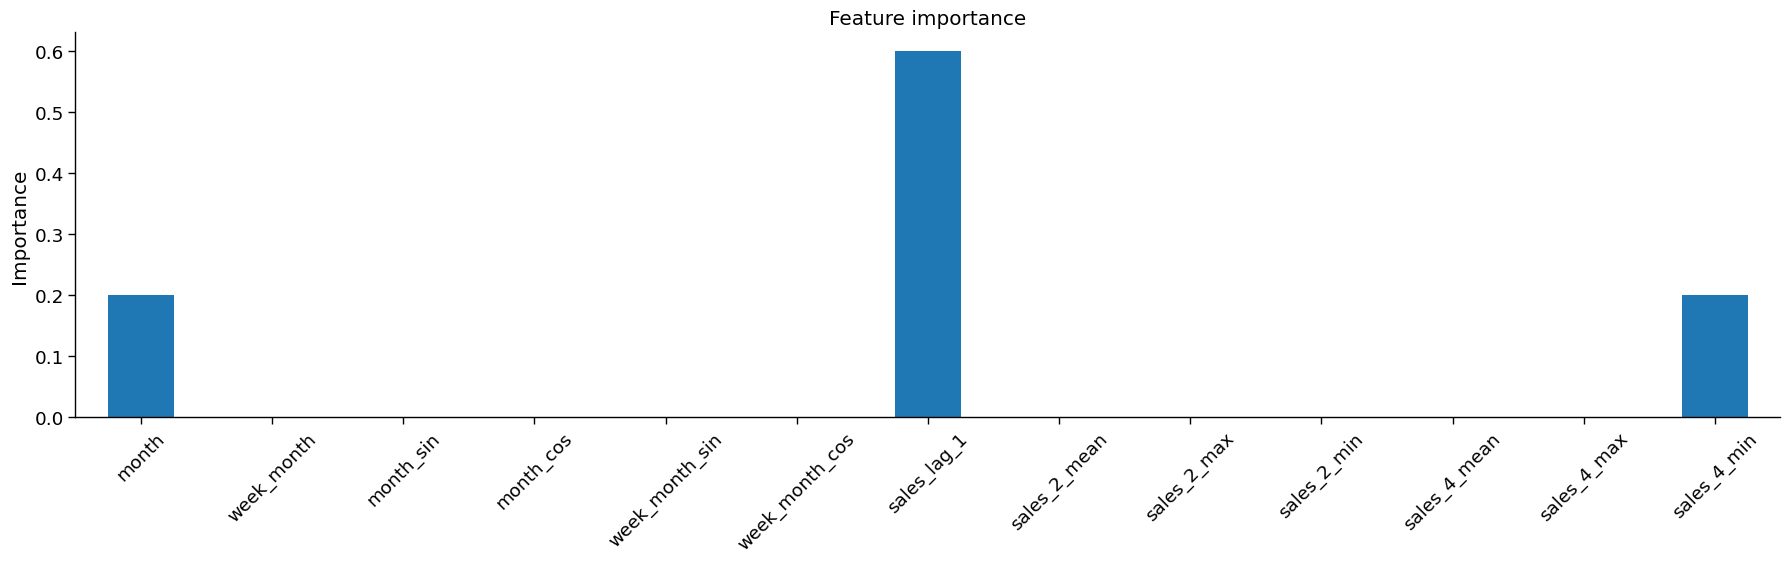

In [25]:
# Create series with feature importance.
tmp = pd.Series(rf_model.feature_importances_)

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")
plt.show()

### 4.4) Lasso

In [26]:
# Lasso model
hyper_param_lasso = {"alpha": 100, "random_state": 0}
lasso_model = Lasso(**hyper_param_lasso).fit(X_train, y_train)
# Predict
lasso_hat = lasso_model.predict(X_test)

# Metrics
lasso_mse = mean_squared_error(y_true=y_test, y_pred=lasso_hat, squared=False,)
lasso_mape = c_mape(y=y_test.values, y_hat= lasso_hat)
print(f"MeaN Squared Error: {lasso_mse: ,.0f}")
print(f"MAPE: {lasso_mape: .2%}")

MeaN Squared Error:  54,603
MAPE:  15.02%


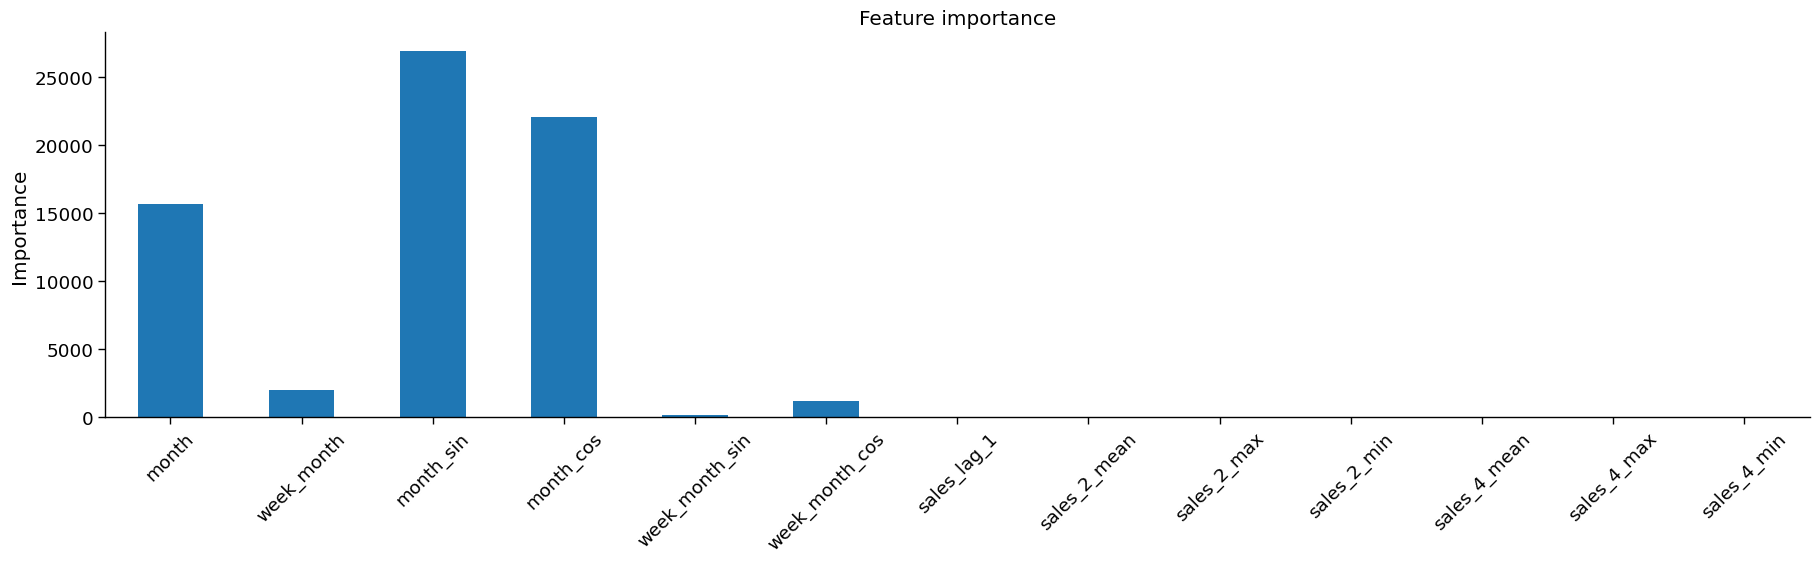

In [27]:
# Create series with feature importance.
tmp = pd.Series(np.abs(lasso_model.coef_))
# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")
plt.show()